In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pathlib as pl
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'

In [43]:
BATCH_SIZE = 256
IMAGE_SIZE = (50, 50)
IMG_SHAPE = IMAGE_SIZE + (3,)

In [44]:
data_dir = pl.Path(data_path + 'Breast Cancer Data')

In [45]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 276397 files belonging to 2 classes.
Using 207298 files for training.


In [46]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    label_mode='categorical',
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 276397 files belonging to 2 classes.
Using 69099 files for validation.


In [47]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [48]:
val_bs = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_bs // 5)
val_ds = val_ds.skip(val_bs // 5)

In [49]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 216
Number of test batches: 54


In [50]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [51]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [52]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(256, 2, 2, 1280)


In [53]:
base_model.trainable = False

In [54]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 25, 25, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 25, 25, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 25, 25, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [55]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(256, 1280)


In [56]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(256, 2)


In [57]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [58]:
base_learning_rate = 1e-04
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [59]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [60]:
len(model.trainable_variables)

2

In [61]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

216/216 [==============================] - 11s 34ms/step - loss: 0.9006 - accuracy: 0.4713
initial loss: 0.90
initial accuracy: 0.47


In [21]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
810/810 [==============================] - 45s 53ms/step - loss: 0.6138 - accuracy: 0.7219 - val_loss: 0.4823 - val_accuracy: 0.7744
Epoch 2/10
810/810 [==============================] - 35s 43ms/step - loss: 0.5159 - accuracy: 0.7584 - val_loss: 0.4679 - val_accuracy: 0.7823
Epoch 3/10
810/810 [==============================] - 35s 43ms/step - loss: 0.4854 - accuracy: 0.7726 - val_loss: 0.4637 - val_accuracy: 0.7854
Epoch 4/10
810/810 [==============================] - 35s 43ms/step - loss: 0.4751 - accuracy: 0.7783 - val_loss: 0.4619 - val_accuracy: 0.7863
Epoch 5/10
810/810 [==============================] - 35s 43ms/step - loss: 0.4707 - accuracy: 0.7804 - val_loss: 0.4604 - val_accuracy: 0.7877
Epoch 6/10
810/810 [==============================] - 35s 43ms/step - loss: 0.4683 - accuracy: 0.7816 - val_loss: 0.4607 - val_accuracy: 0.7864
Epoch 7/10
810/810 [==============================] - 35s 43ms/step - loss: 0.4666 - accuracy: 0.7831 - val_loss: 0.4591 - val_accuracy:

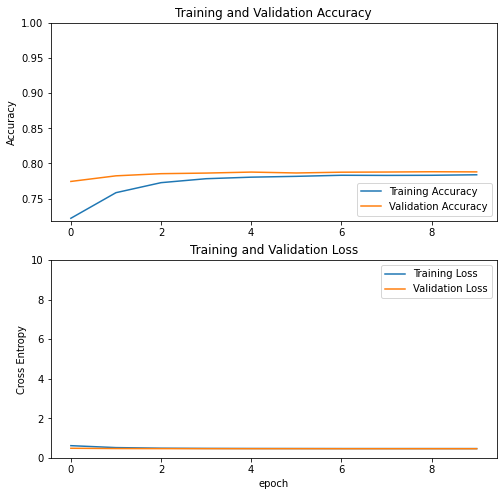

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 58

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [26]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,164,418
Non-trainable params: 96,128
_________________________________________________________________


In [28]:
len(model.trainable_variables)

101

In [29]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/40
810/810 [==============================] - 59s 65ms/step - loss: 0.4548 - accuracy: 0.7908 - val_loss: 0.4352 - val_accuracy: 0.8035
Epoch 11/40
810/810 [==============================] - 50s 61ms/step - loss: 0.4387 - accuracy: 0.8013 - val_loss: 0.4316 - val_accuracy: 0.8056
Epoch 12/40
810/810 [==============================] - 50s 61ms/step - loss: 0.4296 - accuracy: 0.8053 - val_loss: 0.4247 - val_accuracy: 0.8093
Epoch 13/40
810/810 [==============================] - 50s 62ms/step - loss: 0.4246 - accuracy: 0.8087 - val_loss: 0.4196 - val_accuracy: 0.8128
Epoch 14/40
810/810 [==============================] - 49s 60ms/step - loss: 0.4206 - accuracy: 0.8101 - val_loss: 0.4260 - val_accuracy: 0.8114
Epoch 15/40
810/810 [==============================] - 47s 57ms/step - loss: 0.4176 - accuracy: 0.8121 - val_loss: 0.4193 - val_accuracy: 0.8156
Epoch 16/40
810/810 [==============================] - 48s 59ms/step - loss: 0.4145 - accuracy: 0.8137 - val_loss: 0.4214 - val_ac

In [30]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

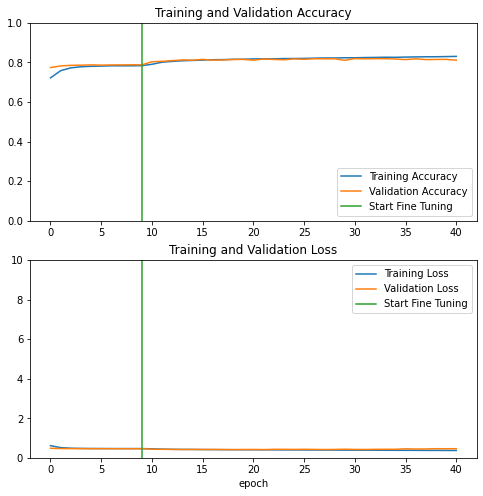

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 10.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

54/54 [==============================] - 2s 39ms/step - loss: 0.4700 - accuracy: 0.8021
Test accuracy : 0.8020833134651184


In [33]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [34]:
predictions = tf.math.argmax(predictions, axis=1)

In [35]:
label_batch = tf.math.argmax(label_batch, axis=1)

Predictions:
 tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0
 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1
 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1
 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0], shape=(256,), dtype=int64)
Labels:
 tf.Tensor(
[0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0

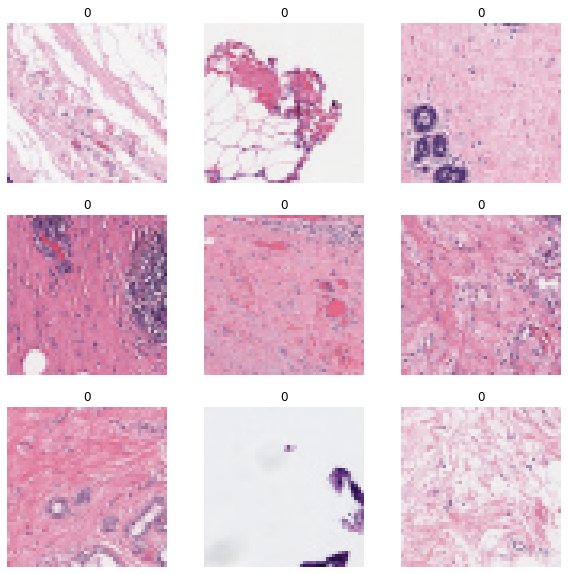

In [36]:
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [37]:
model.save('breast_cancer_keras_mobilenet_v2')

INFO:tensorflow:Assets written to: breast_cancer_keras_mobilenet_v2\assets


In [38]:
new_model = tf.keras.models.load_model('breast_cancer_keras_mobilenet_v2')

In [39]:
import tf2onnx
import onnxruntime as rt

In [40]:
spec = (tf.TensorSpec((None, 50, 50, 3), tf.float32, name="input"),)
output_path = "breast_cancer_keras_mobilenet_v2.onnx"

model_proto, _ = tf2onnx.convert.from_keras(new_model, input_signature=spec, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [42]:
from tensorflow.keras.preprocessing import image
img_path = '16896/1/16896_idx5_x151_y801_class1.png'

img = image.load_img(img_path, target_size=(50, 50))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [43]:
preds = new_model.predict(x)
preds = tf.math.argmax(preds, axis=1)
preds

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>

In [44]:

providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
onnx_pred = m.run(output_names, {"input": x})

onnx_pred= tf.math.argmax(onnx_pred[0], axis=1)

print('ONNX Predicted:', onnx_pred)

# make sure ONNX and keras have the same results
np.testing.assert_allclose(preds, onnx_pred)

ONNX Predicted: tf.Tensor([0], shape=(1,), dtype=int64)
